In [ ]:
!pip install torchviz # just to make nice visualizations of torch model's architectures

# Prerequisites for the task

## Homework I ("Forward propagation")

1. Using PyTorch library, prepare the code the computational graph for the CifarTanhNet. Use `Conv2d`, `MaxPool2d`, and `Linear` classes. Perform the forward propagation on the batch of CIFAR-10 data. The batch size $N_{batch} = 4$ _[practical task, 10% of total score]_.

2. Write down the neural network’s forward pass as equations in a scalar form. Show it as an evolution of the input vector that passes layer-by-layer through the entire network to the output layer. You have to show the size of each vector or matrix. Indices in summation operators must also be specified _[theoretical task, 10% of total score]_.

3. Implement your derived equations as Python functions, use numpy package to store matrices. Perform the forward pass by Pytorch lib and your derived code, make sanity check: ensure that 1) the shapes of output tensors are equal, 2) the differences between outputs are marginal. Compare the speed of Pytorch lib and your implementation. Show these comparisons in your report _[practical task, 10% of total score]_.

4. You are highly encoraged to comment your thoughts details. The price for quality and completeness of comments for HW-I is _[10% of total score]_.

I recommend the following sources of inspiration (but I don't limit you with these materials):
1. For `fc` layers see Lecture 1, p. 30.
2. For `Conv` operation see Lecture 2, p. 14-15.

## Convolutional Neural Network "CifarTanhNet"

CifarTanhNet is a convolutional neural network which has one 2D convolutional layer `|| Conv1 ||` and two fully-connected layers, `|| fc1 ||` and `|| fc2 ||`. Also it has one 2D max-pooling operation `|| Pool ||`, `ReLU` and `Tanh` activation functions. Last but not least, we use an auxiliary reshape operation `|| Reshape ||` which converts 4D tensor to 2D matrix by flattening the dimensions except of batch size.

Neural network's computational graph is defined as follows:

**x** → `|| Conv1 ||` → **a1** → `|| ReLU ||` → **z1** → `|| Pool ||` → **z2** → `|| Reshape ||` → **z2_reshaped** → `|| fc1 ||` → **a3** → `|| Tanh ||` → **z3** → `|| fc2 ||` → **a4** → `|| Tanh ||` → **y**

The hyperparameters are the following:

* `|| Conv1 ||`: input_channels=?, filters_number=8, kernel_size=3, stride=1, padding=0
* `|| Pool ||`: pool_type=max, kernel_size=2, stride=2, padding=0
* `|| fc1 ||`: input_dim = 1800, output_dim = 100, bias = True
* `|| fc2 ||`: input_dim = 100, output_dim = ?, bias = True

By default, we assume that the neural network is trained with Mean Squared Error function to produce one-hot encoded outputs.

# Data and imports preparation

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from torchviz import make_dot
from IPython.display import Image

import time

import numpy as np

In [32]:
import pickle
d = pickle.load(open('cifar10.pkl','rb'))

images_train = d['images_train']
labels_train = d['labels_train']
images_test = d['images_test']
labels_test = d['labels_test']

print('images_train', images_train.shape)
print('labels_train', labels_train.shape)
print('images_test', images_test.shape)
print('labels_test', labels_test.shape)

images_train (50000, 3, 32, 32)
labels_train (50000, 10)
images_test (10000, 3, 32, 32)
labels_test (10000, 10)


# Task 1
Using PyTorch library, prepare the code the computational graph for the CifarTanhNet. Use `Conv2d`, `MaxPool2d`, and `Linear` classes. Perform the forward propagation on the batch of CIFAR-10 data. The batch size $N_{batch} = 4$

---

Fistly, let's discuss the shapes and details of each layer.
CIFAR‐10 images have shape 32×32 with 3 color channels. In PyTorch a batch of images is 4D tensor, so with batch size $N_{batch} = 4$ th input shape become $(4 \text{ batch}, 3 \text{ channels}, 32 \text{ height}, 32 \text{ width})$.

**First convolution layer**

`|| Conv1 ||`: input_channels=?, filters_number=8, kernel_size=3, stride=1, padding=0

- `in_channels` = 3 RGB channels
- `out_channels` = 8 the number of filters, which produce 8 different feature maps
- `kernel_size` = 3 is the size of the sliding window of the filter 3×3
- `stride` = 1 means filter moves 1 pixel at a time across the image
- `padding` = 0 no extra pixels around the image

$$\text{output}
    = \frac{\text{input} - \text{kernel_size} + 2\text{ × padding}}{\text{stride}} + 1
$$

In our case $\text{input_heigh = input_width}$, so for both of the we have $\frac{32 - 3 + 2 \cdot 0}{1} + 1 = 30$, and the conv layer `output shape` is $(N_{\text{batch}}=4, \text{out_channels}=8, \text{heigh}=30, \text{width}=30)$.

**ReLU activation**

Applying a ReLU does not change the shape, it only sets negative values to zero, so after ReLU we still have $(4, 8, 30, 30)$.

**Max pooling**

`|| Pool ||`: pool_type=max, kernel_size=2, stride=2, padding=0

- `kernel_size` = 2 pooling window is 2×2
- `stride` = 2 window moves 2 pixels at a time with no overlap
- `padding` = 0

$$
\text{output} = \frac{\text{input} - \text{kernel_size}}{\text{stride}} + 1
$$

We have $\frac{30 - 2}{2} + 1 = 15$ for both height and width, so the max pool `output shape` is $(N_{\text{batch}}=4, \text{out_channels}=8, \text{heigh}=15, \text{width}=15)$.

**Flatten**

Before a fully‐connected linear layer, PyTorch needs a 2D shape $(\text{batch_size}, \text{ features})$.  All dimensions except the batch dimension have to flatten, so that the last three dimensions of $(4, 8, 15, 15)$ multiply out to $8 \times 15 \times 15 = 1800$ and we get $(N_{\text{batch}}=4, 1800)$.

**First fully connected layer**

`|| fc1 ||`: input_dim = 1800, output_dim = 100, bias = True

Just has output layer with 100 neurons, each neuron is connected to all 1800 inputs and produces one output value. Feeding in a $(N_{\text{batch}}=4, 1800)$ tensor will output $(N_{\text{batch}}=4, 100)$.

**Tanh activation**

Again, a Tanh activation does not change the shape, so it remains $(N_{\text{batch}}=4, 100)$.

**Second fully connected layer**

`|| fc2 ||`: input_dim = 100, output_dim = ?, bias = True

We have 10 classes in CIFAR‐10, so:
- `input_dim` = 100
- `output_dim` = 10

The final output also has tank activation without shape change $(N_{\text{batch}}=4, 10)$.



$$
(4, 3, 32, 32)
\xrightarrow{\text{Conv2d}(3 \rightarrow 8, 3 \times 3, \text{stride}=1, \text{padding}=0)}
(4, 8, 30, 30)
\xrightarrow{\text{ReLU}}
(4, 8, 30, 30)
\xrightarrow{\text{MaxPool2d}(2 \times 2, \text{stride}=2)}
(4, 8, 15, 15)
\xrightarrow{\text{Flatten}}
(4, 1800)
\xrightarrow{\text{Linear}(1800 \rightarrow 100)}
(4, 100)
\xrightarrow{\text{Tanh}}
(4, 100)
\xrightarrow{\text{Linear}(100 \rightarrow 10)}
(4, 10)
\xrightarrow{\text{Tanh}}
(4, 10)
$$



In [2]:
class CifarTanhNet(nn.Module):
  def __init__(self):
    super(CifarTanhNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8,
                            kernel_size=3, stride=1, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(1800, 100)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = torch.tanh(x)

    x = self.fc2(x)
    x = torch.tanh(x)

    return x

Let's create a random input tensor that mimics a batch of 4 CIFAR-10 images
to simulate what a batch of real images would look like when passed into the model for forward propagation.

In [4]:
net = CifarTanhNet()
sample_input = torch.randn(4, 3, 32, 32)
output = net(sample_input)
print(output.shape)

torch.Size([4, 10])


And here is the backward computation graph generated by PyTorch’s autograd engine. It contains only the differentiable operations that PyTorch is tracking for gradient computation.

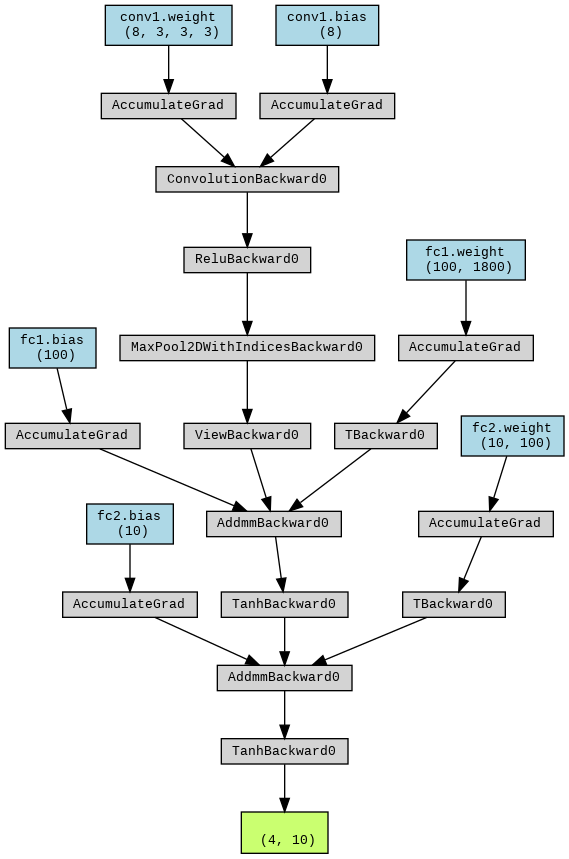

In [8]:
make_dot(output, params=dict(net.named_parameters())).render("network_architecture", format="png")
Image(filename="network_architecture.png")

Layer-by-layer forward breakdown with output shapes and parameters:

(4, 3, 32, 32)
 → Conv2d(3→8) → (4, 8, 30, 30)
 → ReLU
 → MaxPool2d → (4, 8, 15, 15)
 → Flatten → (4, 1800)
 → Linear(1800→100) → (4, 100)
 → Tanh
 → Linear(100→10) → (4, 10)
 → Tanh

The -1 is a placeholder that means "any batch size"!


In [14]:
torchsummary.summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
         MaxPool2d-2            [-1, 8, 15, 15]               0
            Linear-3                  [-1, 100]         180,100
            Linear-4                   [-1, 10]           1,010
Total params: 181,334
Trainable params: 181,334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.69
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


# Task 2
Write down the neural network’s forward pass as equations in a scalar form. Show it as an evolution of the input vector that passes layer-by-layer through the entire network to the output layer. You have to show the size of each vector or matrix. Indices in summation operators must also be specified

---

I will show an example of the forward pass **in scalar form** for a **single** CIFAR-10 image as it goes through each layer in `CifarTanhNet` model. In practice, when we process a batch of images at once, the first dimension become $N_{batch} = 4$, as was descibed in the first task.

The single‐image forward pass is:

$$
x \;\xrightarrow{\text{conv}}
z^{(1)} \;\xrightarrow{\text{ReLU}}\;
a^{(1)} \;\xrightarrow{\text{maxpool}}\;
p^{(1)}
\;\xrightarrow{\text{flatten}}\;
f
\;\xrightarrow{\text{fc1}}\;
z^{(2)} \;\xrightarrow{\tanh}\;
a^{(2)}
\;\xrightarrow{\text{fc2}}\;
z^{(3)} \;\xrightarrow{\tanh}\
$$

---

**Notation and shapes**

Let the **input image** be $x \in \mathbb{R}^{3 \times 32 \times 32}$, where the 3 is for RGB channels, and $32\times 32$ are the spatial dimensions. The network layers:

  1. **Conv2d**  
     $\text{in_channels} = 3,\ \text{out_channels} = 8,\ \text{kernel\_size} = 3,\ \text{padding} = 0,\ \text{stride} = 1$  
     $\Rightarrow$ output shape is $\mathbb{R}^{8 \times 30 \times 30}$

  2. **ReLU** activation
      
      $\Rightarrow$ output shape is $\mathbb{R}^{8 \times 30 \times 30}$

  3. **MaxPool2d**

     $\text{kernel\_size} = 2$ and $\text{stride} = 2$  
     $\Rightarrow$ output shape is $\mathbb{R}^{8 \times 15 \times 15}$

  4. **Flatten**
  
     $\Rightarrow$ output shape is $\mathbb{R}^{1800}$

  5. **Linear (fc1)** from $1800 \to 100$  

     $\Rightarrow$ output shape is $\mathbb{R}^{100}$

  6. **tanh** activation
  
     $\Rightarrow$ output shape is $\mathbb{R}^{100}$

  7. **Linear (fc2)** from $100 \to 10$  

     $\Rightarrow$ output shape is $\mathbb{R}^{10}$

  8. **tanh** activation

     $\Rightarrow$ output shape is $\mathbb{R}^{10}$

Let's denote:

- $w^{(1)}_{k,\,c,\,i,\,j}$ and $b^{(1)}_k$ for the **conv layer** weights/bias
- $w^{(2)}_{u,\,r}$ and $b^{(2)}_u$ for the **fc1** weights/bias
- $w^{(3)}_{v,\,u}$ and $b^{(3)}_v$ for the **fc2** weights/bia

---

**Convolution with ReLU activation**

Let $z^{(1)}_{k,\,p,\,q}$ be the output before ReLU:

$$
  z^{(1)}_{k,\,p,\,q}
  \;=\;
  b^{(1)}_{k}
  \;+\;
  \sum_{c=1}^{3}
  \sum_{i=0}^{2}
  \sum_{j=0}^{2}
    w^{(1)}_{k,\,c,\,i,\,j}\,
    \cdot x_{c,\,p + i,\, q + j}
  \quad
  \text{for } k = 1,\dots,8,\
              p = 0,\dots,29,\
              q = 0,\dots,29
$$

  - $k$ indexes the output channel $k \in \{1,\dots,8\}$
  - $c$ indexes the input channel $c \in \{1,2,3\}$
  - $p,q$ index the spatial positions of the output 30×30
  - $i,j$ index the 3×3 convolution kernel

**Shape** of $z^{(1)}$ is $\mathbb{R}^{8 \times 30 \times 30}$

Then apply ReLU elementwise:

$$
  a^{(1)}_{k,\,p,\,q}
  \;=\;
  \max\bigl\{\,0,\; z^{(1)}_{k,\,p,\,q}\bigr\}
$$

**Shape** of $a^{(1)}$ is also $\mathbb{R}^{8 \times 30 \times 30}$

---

**Max pooling**

With a 2×2 kernel and stride 2, we reduce each spatial dimension by half from 30 to 15. Let $p^{(1)}_{k,\,P,\,Q}$ denote the max-pooled output:

$$
  p^{(1)}_{k,\,P,\,Q}
  \;=\;
  \max_{\alpha \in \{0,1\},\;\beta \in \{0,1\}}
    \Bigl\{
      a^{(1)}_{\,k,\,2P + \alpha,\,2Q + \beta}
    \Bigr\},
$$
for
$$
  P = 0,\dots,14,\quad
  Q = 0,\dots,14
$$

**Shape** of $p^{(1)}$ is $\mathbb{R}^{8 \times 15 \times 15}$

---

**Flatten**

We flatten $p^{(1)}$ into a single 1800-dimensional vector $f \in \mathbb{R}^{1800}$:

$$
  f_{r}
  \;=\;
  p^{(1)}_{\,k,\,P,\,Q},
$$
where
$$
  r \;=\; k \times (15 \times 15) \;+\; P \times 15 \;+\; Q,
$$

$$
  k = 0,\dots,7;\quad
  P=0,\dots,14;\quad
  Q=0,\dots,14
$$

**Shape** $f \;\in\; \mathbb{R}^{1800}$

---

**First fully connected with tanh activation**

Let $z^{(2)} \in \mathbb{R}^{100}$ be the pre-activation vector:

$$
  z^{(2)}_{\,u}
  \;=\;
  b^{(2)}_{\,u}
  \;+\;
  \sum_{r=1}^{1800}
    w^{(2)}_{\,u,\,r}
    \;f_{\,r},
  \quad
  \text{for } u = 1,\dots,100
$$

**Shape** of $z^{(2)}$ is $\mathbb{R}^{100}$

After $\tanh$ activation:

$$
  a^{(2)}_{\,u}
  \;=\;
  \tanh\!\Bigl(z^{(2)}_{\,u}\Bigr),
  \quad u=1,\dots,100
$$

**Shape** of $a^{(2)}$ is also $\mathbb{R}^{100}$

---

 **Second fully connected with tanh activation**

We map from 100 neurons to 10 output classes and denote $z^{(3)} \in \mathbb{R}^{10}$ the pre-activation vector:

$$
  z^{(3)}_{\,v}
  \;=\;
  b^{(3)}_{\,v}
  \;+\;
  \sum_{u=1}^{100}
    w^{(3)}_{\,v,\,u}
    \;a^{(2)}_{\,u},
  \quad
  v = 1,\dots,10
$$

**Shape** of $z^{(3)}$ is $\mathbb{R}^{10}$

Applying $\tanh$ again:

$$
  a^{(3)}_{\,v}
  \;=\;
  \tanh\!\Bigl(z^{(3)}_{\,v}\Bigr),
  \quad
  v = 1,\dots,10
$$

 **Shape** of $a^{(3)}$ is also $\mathbb{R}^{10}$

This final vector $a^{(3)} \in \mathbb{R}^{10}$ is the network output with one logit / activation per CIFAR-10 class.

---

In practice, we feed **batches** of samples, and in our case $N_{batch} = 4$ with images of size $3 \times 32 \times 32$ each:
$$
  X \;\in\; \mathbb{R}^{4 \times 3 \times 32 \times 32}
$$


After Convolution + ReLU + Pool, we get a batch of feature maps, shape $\mathbb{R}^{4 \times 8 \times 15 \times 15}$. Then we flatten each of the 4 samples $F \,\in\, \mathbb{R}^{4 \times 1800}$.

Then first fully connected layer with tanh activation, suppose $W^{(2)} \in \mathbb{R}^{100 \times 1800}$ and $b^{(2)} \in \mathbb{R}^{100}$. In matrix form, for a batch of 4:
$$
  Z^{(2)} \;=\; F \, \bigl(W^{(2)}\bigr)^{\mathsf{T}} \;+\; b^{(2)},
$$
   where $F$ is $4 \times 1800$, $W^{(2)T}$ is $1800 \times 100$, so $Z^{(2)}$ is $4 \times 100$. We broadcast $b^{(2)}$ row‐wise for each of the 4 samples and apply $\tanh$ elementwise:
$$
  A^{(2)} = \tanh\bigl(Z^{(2)}\bigr),
  \quad
  A^{(2)} \in \mathbb{R}^{4 \times 100}
$$


Second fully connected with activation and same logic, let $W^{(3)} \in \mathbb{R}^{10 \times 100}$ and $b^{(3)} \in \mathbb{R}^{10}$, in matrix form:  
$$
  Z^{(3)}
  \;=\;
  A^{(2)} \, \bigl(W^{(3)}\bigr)^{\mathsf{T}}
  \;+\; b^{(3)},
  \quad
  Z^{(3)} \in \mathbb{R}^{4 \times 10}
$$
$$
  A^{(3)}
  \;=\;
  \tanh\!\bigl(Z^{(3)}\bigr),
  \quad
  A^{(3)} \in \mathbb{R}^{4 \times 10}
$$

The final output is one 10‐dimensional output vector per sample
$$
  A^{(3)} \;=\; \bigl[a^{(3)}_1,\; a^{(3)}_2,\; a^{(3)}_3,\; a^{(3)}_4\bigr] \;\in\; \mathbb{R}^{4 \times 10}
$$



# Task 3
Implement your derived equations as Python functions, use numpy package to store matrices. Perform the forward pass by Pytorch lib and your derived code, make sanity check: ensure that 1) the shapes of output tensors are equal, 2) the differences between outputs are marginal. Compare the speed of Pytorch lib and your implementation. Show these comparisons in your report.

This first function is suppose to read off its parameters and store them in NumPy arrays to ensure both implementations use the same random weights/biases

In [17]:
def extract_torch_params(model):
  Wconv1 = model.conv1.weight.detach().cpu().numpy()
  bconv1 = model.conv1.bias.detach().cpu().numpy()

  Wfc1 = model.fc1.weight.detach().cpu().numpy()
  bfc1 = model.fc1.bias.detach().cpu().numpy()

  Wfc2 = model.fc2.weight.detach().cpu().numpy()
  bfc2 = model.fc2.bias.detach().cpu().numpy()

  return {
      'Wconv1': Wconv1,
      'bconv1': bconv1,
      'Wfc1':   Wfc1,
      'bfc1':   bfc1,
      'Wfc2':   Wfc2,
      'bfc2':   bfc2
      }

Now let's implement each step of the original network manually for a batch of images shaped (N, C, H, W)

In [18]:
# my favorite functions!
def relu_np(x):
  return np.maximum(x, 0.)

def tanh_np(x):
  return np.tanh(x)

def flatten_np(x):
  N, C, H, W = x.shape
  return x.reshape(N, C*H*W)

Implementing layers

A lot of details are skipped for the sake of simplicity, given that we know the sizes of kernels, padding, etc.

In [19]:
def conv2d_np(x, W, b, stride=1, padding=0):
  """
  N - batch_size=4
  Cin - input channels=3
  Cout - output features maps=8
  H - height=32
  W - width=32
  kH - kernel height=3
  kW - kernel width=3
  H_out - height after convolution=30
  W_out - width after convolution=30

  x: shape (N, Cin, H, W)
  W: shape (Cout, Cin, kH, kW)
  b: shape (Cout,)

  returns: y of shape (N, Cout, H_out, W_out)
  """
  N, Cin, H, W_ = x.shape
  Cout, _, kH, kW = W.shape

  # output spatial size H_out = (H - kH) // stride + 1 = H - 3 + 1 = H-2
  H_out = (H - kH + 2*padding)//stride + 1
  W_out = (W_ - kW + 2*padding)//stride + 1

  # the padding is ignored for simplicity as it is 0
  y = np.zeros((N, Cout, H_out, W_out), dtype=x.dtype)
  for n in range(N):
    for cout in range(Cout):
      for h_out in range(H_out):
        for w_out in range(W_out):
          acc = b[cout]
          # 3x3 kernel
          for cin in range(Cin):
            for i in range(kH):
              for j in range(kW):
                # element-wise corresponding input pixel and kernel weight multiplication
                acc += (W[cout, cin, i, j] * x[n, cin, h_out + i, w_out + j])
          y[n, cout, h_out, w_out] = acc

  return y

In [20]:
def maxpool2d_2x2_np(x):
  """
  x: shape (N, C, H, W)

  returns: y of shape (N, C, H/2, W/2)
  """
  N, C, H, W_ = x.shape
  H_out = H // 2
  W_out = W_ // 2

  y = np.zeros((N, C, H_out, W_out), dtype=x.dtype)
  for n in range(N):
    for c in range(C):
      for ph in range(H_out):
        for pw in range(W_out):
          # top left corner row and col indexes of 2x2 window
          h0 = 2*ph
          w0 = 2*pw
          patch = x[n, c, h0:h0+2, w0:w0+2] # extract values in window
          y[n, c, ph, pw] = patch.max() # get max value in window

  return y

In [21]:
def linear_np(x, W, b):
  """
  x: shape (N, in_features)
  W: shape (out_features, in_features)
  b: shape (out_features,)

  returns shape (N, out_features)
  """
  return x @ W.T + b

Putting it all together...

In [22]:
def cifar_tanh_net_np(X, params):
  """
  X: shape (N, 3, 32, 32)
  params: dictionary with keys [Wconv1, bconv1, Wfc1, bfc1, Wfc2, bfc2]

  returns shape (N, 10)
  """
  out = conv2d_np(X, params['Wconv1'], params['bconv1'], stride=1, padding=0)
  out = relu_np(out)

  out = maxpool2d_2x2_np(out)

  out = flatten_np(out)

  out = linear_np(out, params['Wfc1'], params['bfc1'])  # (N, 100)
  out = tanh_np(out)

  out = linear_np(out, params['Wfc2'], params['bfc2'])  # (N, 10)
  out = tanh_np(out)

  return out

Final test!

In [30]:
model = CifarTanhNet()
batch_size = 4
x_torch = torch.randn(batch_size, 3, 32, 32)
x_np = x_torch.numpy()

# forward pass in PyTorch
t0 = time.time()
with torch.no_grad():
  out_torch = model(x_torch)
t1 = time.time()
pytorch_time = t1 - t0

# extract parameters
params_np = extract_torch_params(model)

# forward pass in NumPy
t2 = time.time()
out_np = cifar_tanh_net_np(x_np, params_np)
t3 = time.time()
numpy_time = t3 - t2

# comparison
print("PyTorch output shape:", out_torch.shape)
print("NumPy output shape:", out_np.shape)

out_torch_np = out_torch.numpy()
diff = np.abs(out_torch_np - out_np).max()
print(f"Max abs difference between PyTorch vs NumPy: {diff:.10f}")

print(f"PyTorch forward pass time: {pytorch_time*1e3:.3f} ms")
print(f"NumPy forward pass time: {numpy_time*1e3:.3f} ms")

PyTorch output shape: torch.Size([4, 10])
NumPy output shape: (4, 10)
Max abs difference between PyTorch vs NumPy: 0.0000001788
PyTorch forward pass time: 2.094 ms
NumPy forward pass time: 589.338 ms


Both PyTorch and NumPy produced the exact same shaped numerically close output, but there's a huge difference in performance with PyTorch being much faster, thanks to its optimized backend